# Computing the Lagrangian Descriptors of Dynamical Systems

## GitHub repository

The library pylds can downloaded from https://github.com/broncio123/lds

<span style="color:red"><b>NOTE</b></span> This is part of an ongoing software development project by the [CHAMPS group](https://github.com/champsproject).

No guarantee the code is bug-free. Contact the developers or raise an issue in the repo for any problems you encounter.

## Basic setup: IMPORTANT

BEFORE running this Notebook we assume the following 

* This notebook runs with Python Version `>= 3`

* `conda` si up-to-date. If not, in the terminal (Linux/Mac) or the `Conda Prompt` (Windows)

```bash
conda update --all
```

If you're running this notebook and it works fine. That's good news!

If you get error, please, try the proposed instructions in the next Subsection. 

## Package requirements

* DO RUN the following lines, only if the current Notebook doesn't execute properly.
* DON'T RUN the following lines, if `requirements.txt` already satisfied or if Notebook runs fine. 

If `pip` not installed within `conda` environment, execute the cell below

```bash
conda install pip==20.0.2
```

Install _package dependencies_

```bash
pip install -r requeriments.txt
```

## Benchmark examples

In [1]:
import pylds
from pylds.base import compute_lagrangian_descriptor, perturb_field
from pylds.tools import draw_all_lds
from pylds.vector_fields import HamCenter1D, HamSaddle1D, Duffing1D, HamSN1D, Duffing1D_inverted, forcing, HenonHeiles_potential, HenonHeiles_vector_field, NFSaddle_potential, NFSaddle_vector_field

Integration took 0.3 s


In [2]:
# Integration parameters
tau = 12

# LDp, p-value
p_value = 0.5

# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [100, 100]

### Some simple systems

#### Hamilton Centre

_Energy_

\begin{equation*}
H(x, p_x) = \frac{\omega}{2} (p_x^2 + x^2), \quad \omega > 0
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} = f_1(x, p_x) = \omega p_x \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} = f_2(x, p_x) = -\omega x
 \end{align*}

In [3]:
# Integration parameters
tau = 12

# LDp, p-value
p_value = 0.5

# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [100, 100]

In [4]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = HamCenter1D

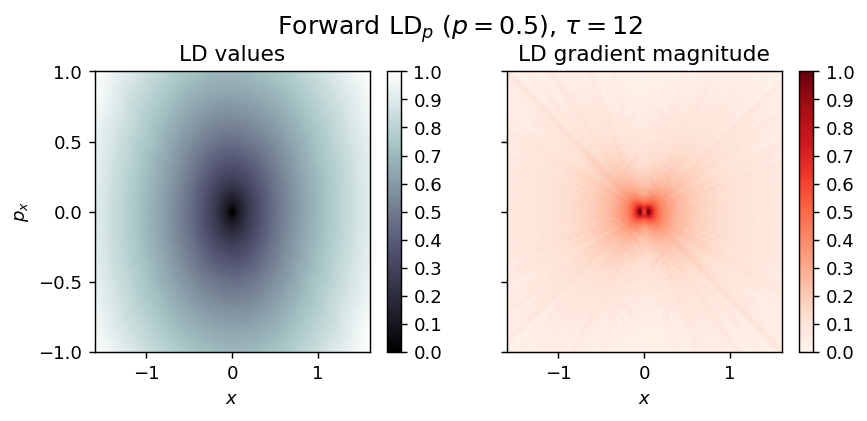

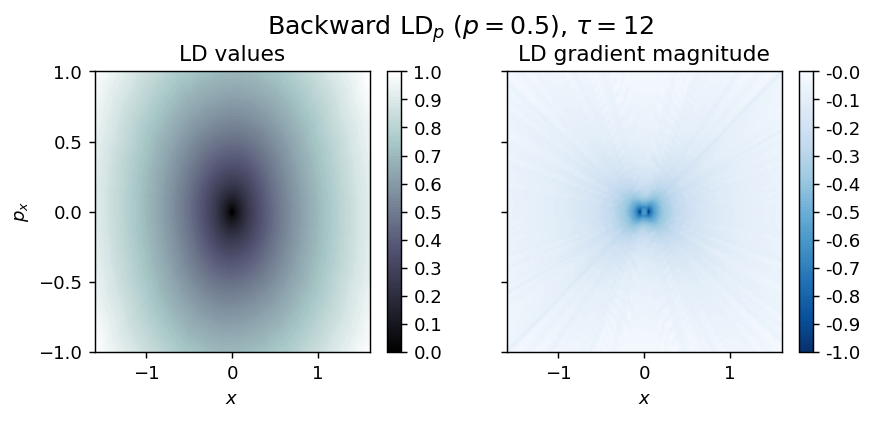

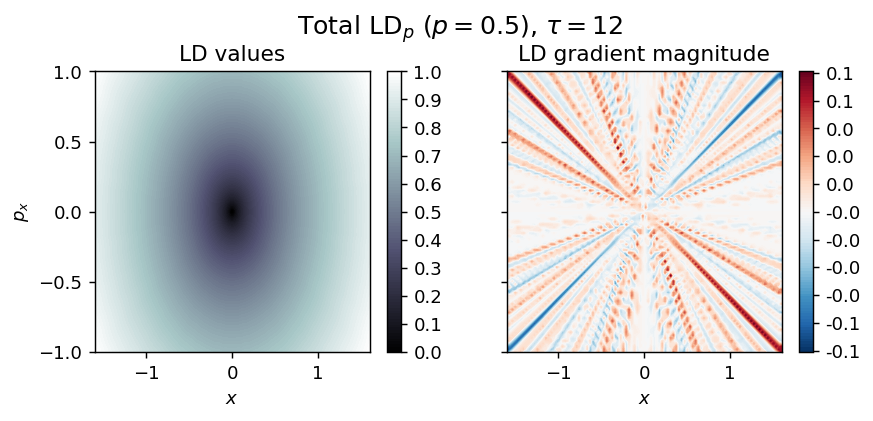

In [5]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)

draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value)

#### Hamilton Saddle

_Energy_

\begin{equation*}
H(x, p_x) = \frac{\lambda}{2}( p_x^2 -  x^2 ), \quad \lambda > 0
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} = f_1(x, p_x) = -\lambda p_x \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} = f_2(x, p_x) = \lambda x
 \end{align*}

In [3]:
# Integration parameters
tau = 12

# LDp, p-value
p_value = 0.5

# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [100, 100]

In [4]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = HamSaddle1D

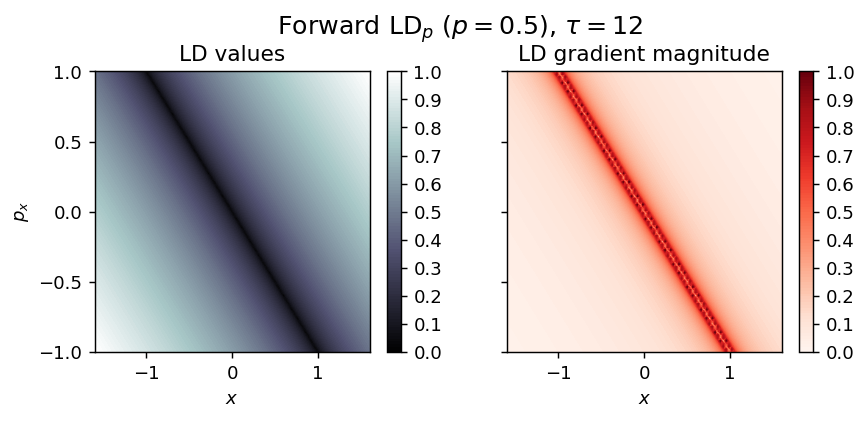

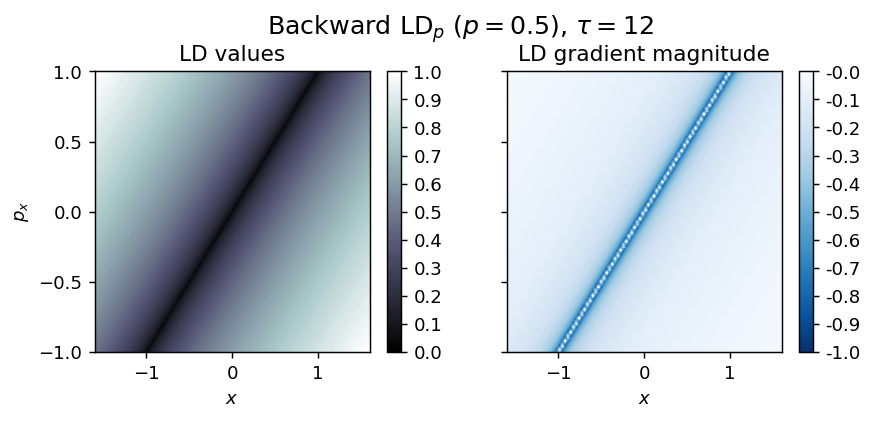

In [5]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)

draw_all_lds(LD_forward, [], grid_parameters, tau, p_value)
draw_all_lds([], LD_backward, grid_parameters, tau, p_value)

#### Duffing oscillator

_Energy_

\begin{equation*}
H(x, p_x) = \frac{1}{2} (p_x^2 - x^2 + \frac{1}{2} x^4)
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} = f_1(x, p_x) = p_x \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} = f_2(x, p_x) = x - x^3
 \end{align*}

In [9]:
# Integration parameters
tau = 12

# LDp, p-value
p_value = 0.5

# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [100, 100]

In [10]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = Duffing1D

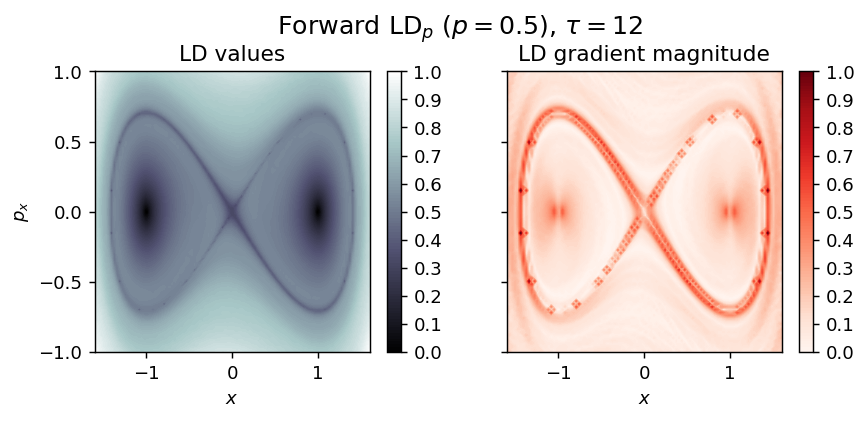

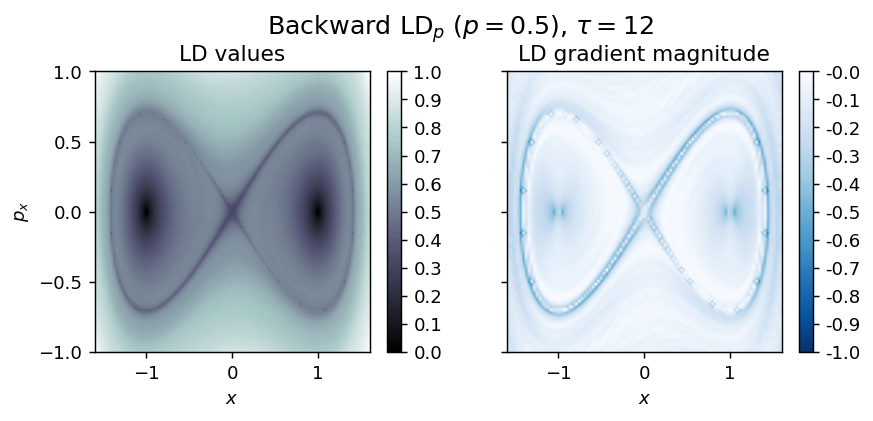

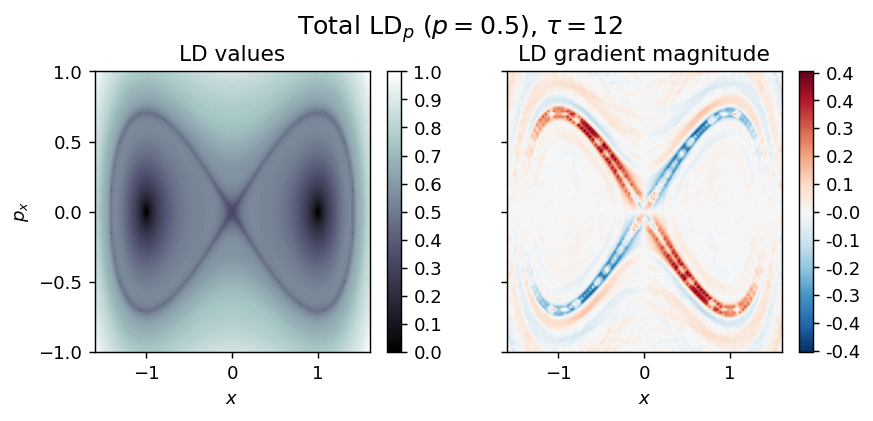

In [11]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)

draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value)

### Example of a perturbed system

#### Harmonically perturbed Duffing oscillator

_Energy_ 

\begin{equation*}
H(x, p_x, t) = \frac{1}{2} (p_x^2 - x^2 + \frac{1}{2} x^4)
\end{equation*}

_Vector field_ whith _time-dependent harmonic forcing_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} = f_1(x, p_x) = p_x \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} + + \eta(t) = f_2(x, p_x) = x - x^3 + \eta(t)
 \end{align*}
 
where

\begin{align*}
\eta(t) = A \cdot sin(\omega t)
\end{align*}

with $A$ and $\omega$ the amplitude and the frequency of the perturbation.

In [12]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field_original = Duffing1D
vector_field = perturb_field(vector_field_original, forcing)

In [15]:
%matplotlib widget
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)

draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value, interactive=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='grad_min', max=0.99, step=0.01), FloatSlider(value=1…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=-1.0, description='grad_min', max=-0.01, min=-1.0, step=0.01), FloatSl…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=-0.9436576323042044, description='grad_min', max=0.9336576323042145, m…

Run the line below to exit widget environment. This will be useful for the following figures as they're not interactive. 

In [16]:
%matplotlib inline

### Example of systems that blow up in finite time

#### Hamilton Saddle-Node

_Energy_

\begin{equation*}
H(x, p_x) = \frac{1}{2} (p_x^2 + x^2 + \frac{2}{3} x^3)
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} = f_1(x, p_x) = p_x \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} = f_2(x, p_x) = -x - x^2
 \end{align*}

In [17]:
# Integration parameters
tau = 8

# Lp-norm, p-value
p_norm = 1/2

# Mesh parameters
x_min,x_max = [-1.5, 1]
y_min,y_max = [-1, 1]

# Box boundaries for Variable Time Integration
box_x_min, box_x_max = [-6, 6]

In [18]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = HamSN1D
box_boundaries = [(box_x_min, box_x_max)]

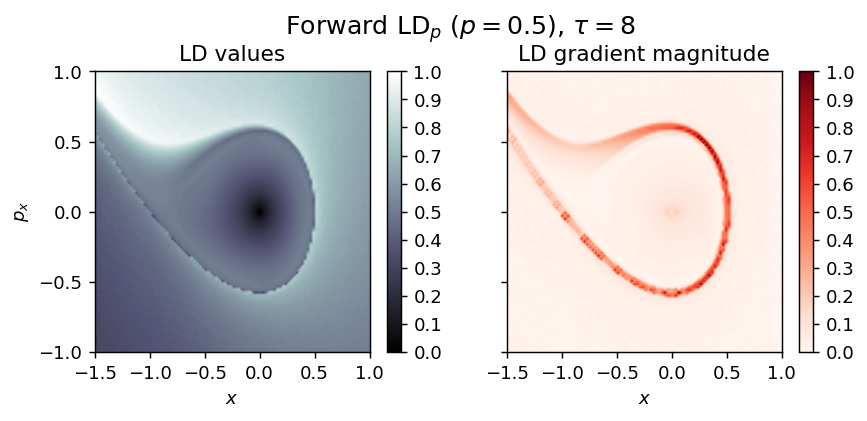

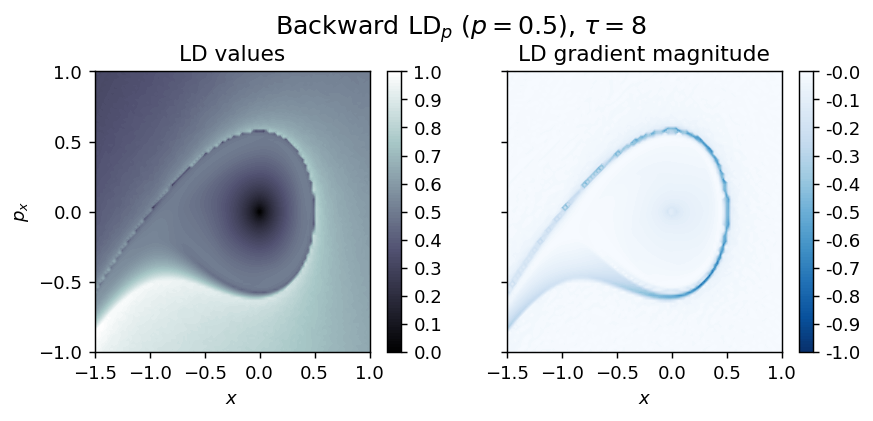

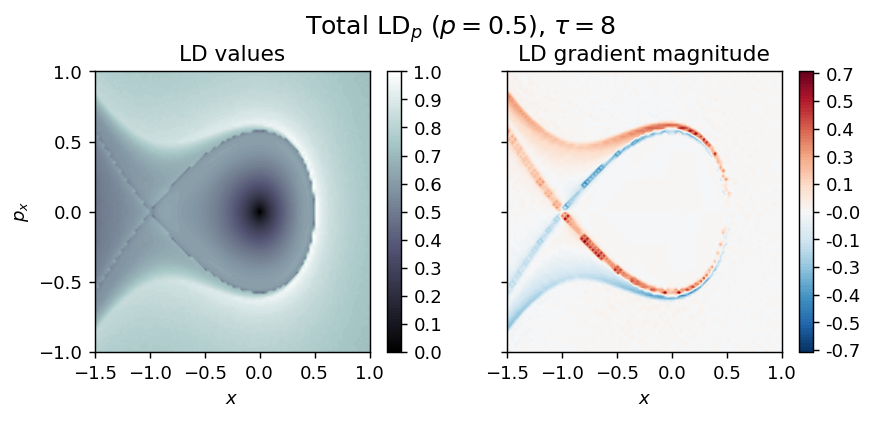

In [20]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value, box_boundaries)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value, box_boundaries)

draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value)

#### Inverted Duffing oscillator

_Energy_

\begin{equation*}
H(x, p_x) = \frac{1}{2} (p_x^2 + x^2 - \frac{1}{2} x^4)
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} = f_1(x, p_x) = p_x \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} = f_2(x, p_x) = -x + x^3
 \end{align*}

In [21]:
# Integration parameters
tau = 10

# Lp-norm, p-value
p_norm = 1/2

# Mesh parameters
x_min,x_max = [-1.5, 1.5]
y_min,y_max = [-1, 1]

# Box boundaries for Variable Time Integration
box_x_min, box_x_max = [-6, 6]

In [22]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = Duffing1D_inverted
box_boundaries = [(box_x_min, box_x_max)]

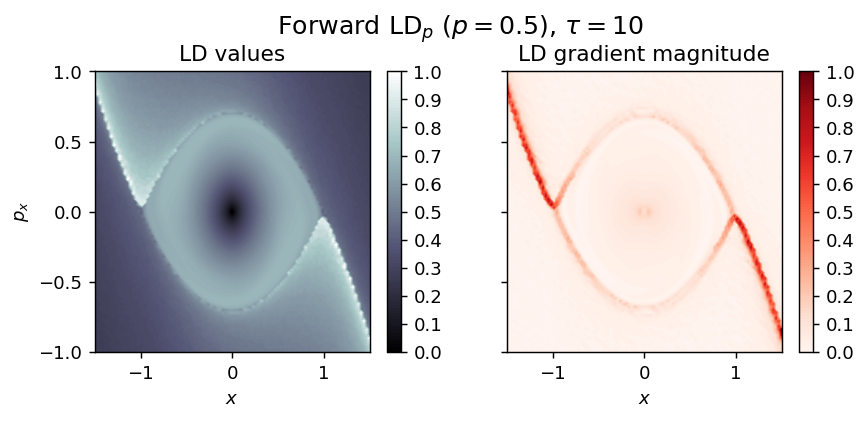

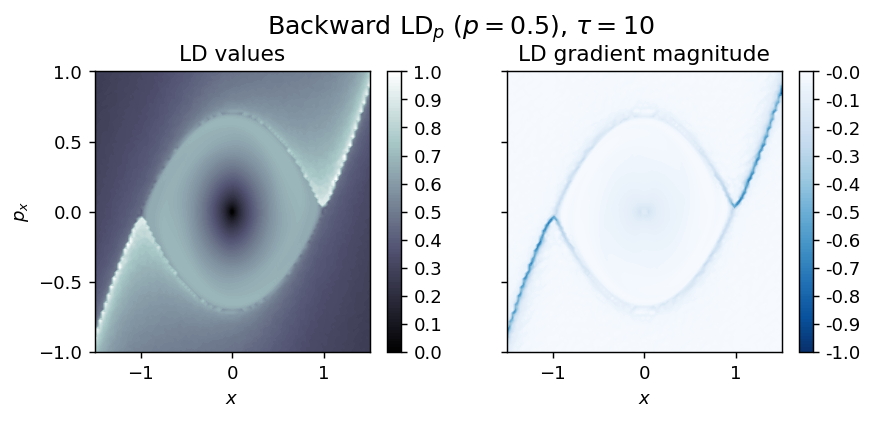

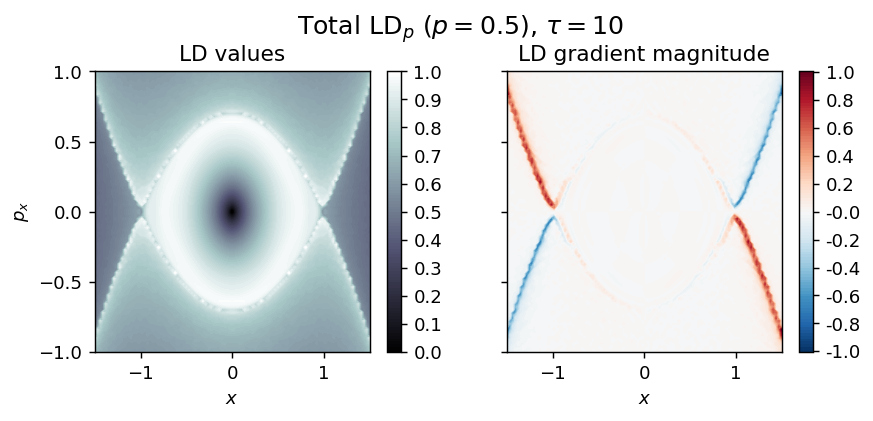

In [24]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value, box_boundaries)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value, box_boundaries)

draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value)

### High-dimensional Hamiltonian systems

_Energy_

\begin{equation*}
H(x, p_x) = K + V = \frac{1}{2} (p_x^2 + p_y^2) + x^2 y - \frac{1}{3} y^3
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} =  p_x \\
 \dot{y} &= \frac{\partial H}{\partial p_y} = p_y  \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} =  -x - 2 x y \\
 \dot{p}_y &= -\frac{\partial H}{\partial y} =  -x^2 -y + y^2 \\
 \end{align*}

#### Henon-Heiles

In [25]:
# Integration parameters
tau = 50

# Lp-norm, p-value
p_value = 1/2

# Mesh visualisation slice parameters
H0 = 1/5 # Energy

ax1_min,ax1_max = [-0.6, 1.2]
ax2_min,ax2_max = [-0.65, 0.65]
N1, N2 = [100, 100]

# Box escape condition
box_boundaries = [[-5, 5], [-5, 5]]

# Miscellaneous grid parameters
dims_fixed = [1,0,0,0] # Variable ordering (x1 x2 y1 y2)
dims_fixed_values = [0] # This can also be an array of values
dims_slice = [0,1,0,1] # Visualisation slice
momentum_sign = 1 # Direction of momentum that defines the slice - (1) positive / (-1) negative

In [26]:
potential_energy = HenonHeiles_potential
vector_field = HenonHeiles_vector_field

slice_parameters = [[ax1_min, ax1_max, N1],[ax2_min, ax2_max, N2]]

grid_parameters = {
        'slice_parameters' : slice_parameters,
        'dims_slice' : dims_slice,
        'dims_fixed' : [dims_fixed, dims_fixed_values],
        'momentum_sign' : momentum_sign,
        'potential_energy': potential_energy,
        'energy_level': H0
    }

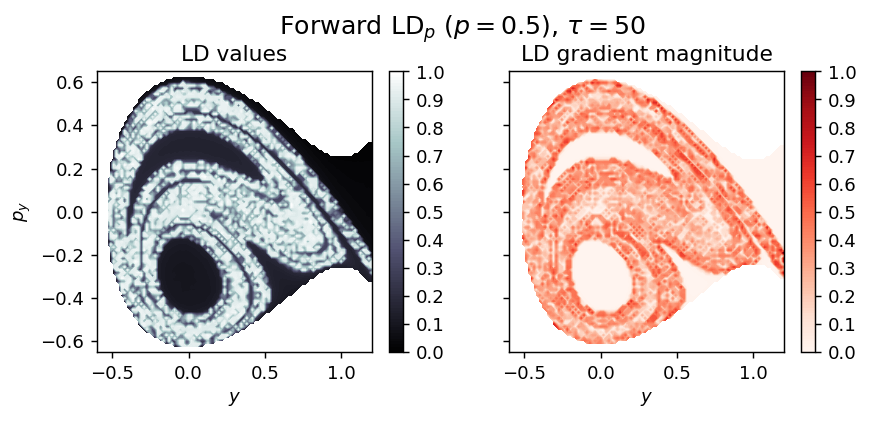

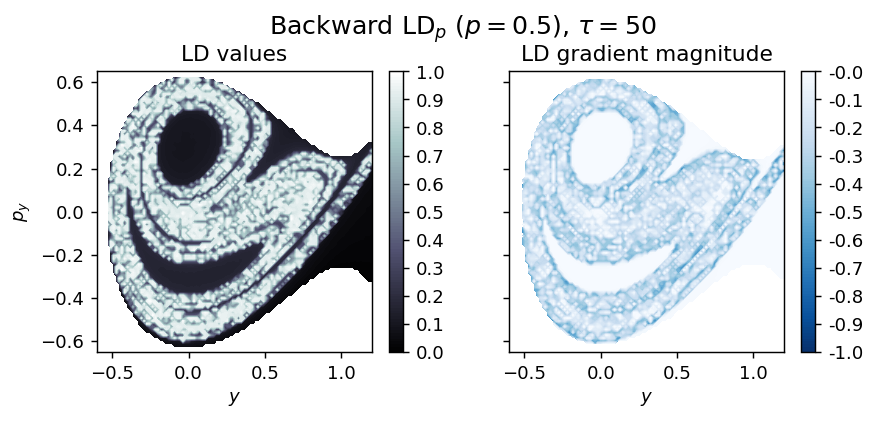

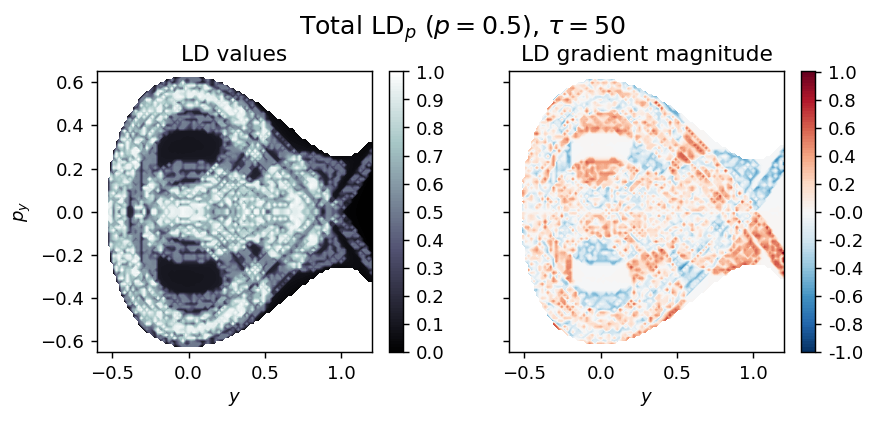

In [28]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value, box_boundaries)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value, box_boundaries)

draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value)

#### Index-1 Normal Form Saddle

_Energy_

\begin{equation*}
H(x, p_x) = K + V = \frac{1}{2} (p_x^2 + p_y^2) + \frac{1}{2}(y^2 - x^2)
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} =  p_x \\
 \dot{y} &= \frac{\partial H}{\partial p_y} = p_y  \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} =  x \\
 \dot{p}_y &= -\frac{\partial H}{\partial y} =  -y \\
 \end{align*}

In [29]:
# Integration parameters
tau = 10

# Lp-norm, p-value
p_value = 1/2

# Mesh visualisation slice parameters
H0 = 1 # Energy
ax1_min,ax1_max = [-2, 2]
ax2_min,ax2_max = [-2, 2]
N1, N2 = [100, 100]

# Box escape condition
box_boundaries = False

# Miscellaneous grid parameters
dims_fixed = [0,1,0,0] # Variable ordering (x1 x2 y1 y2)
dims_fixed_values = [0] # This can also be an array of values
dims_slice = [1,0,1,0] # Visualisation slice
momentum_sign = -1 # Direction of momentum that defines the slice - (1) positive / (-1) negative

In [30]:
potential_energy = NFSaddle_potential
vector_field = NFSaddle_vector_field

slice_parameters = [[ax1_min, ax1_max, N1],[ax2_min, ax2_max, N2]]

grid_parameters = {
        'slice_parameters' : slice_parameters,
        'dims_slice' : dims_slice,
        'dims_fixed' : [dims_fixed, dims_fixed_values],
        'momentum_sign' : momentum_sign,
        'potential_energy': potential_energy,
        'energy_level': H0
    }

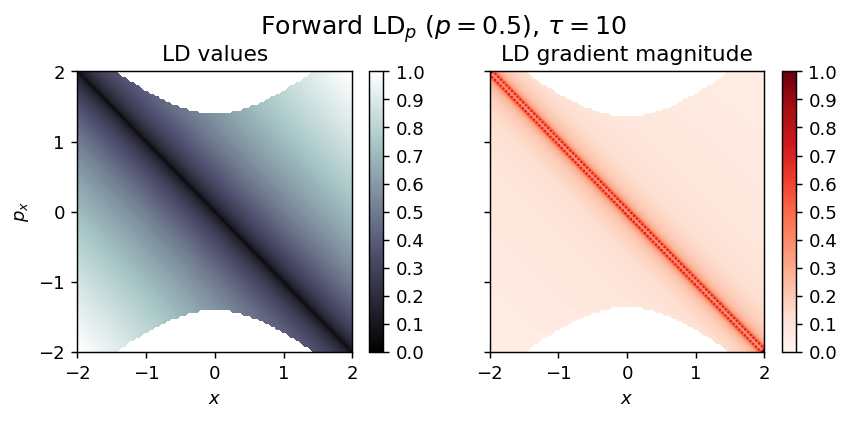

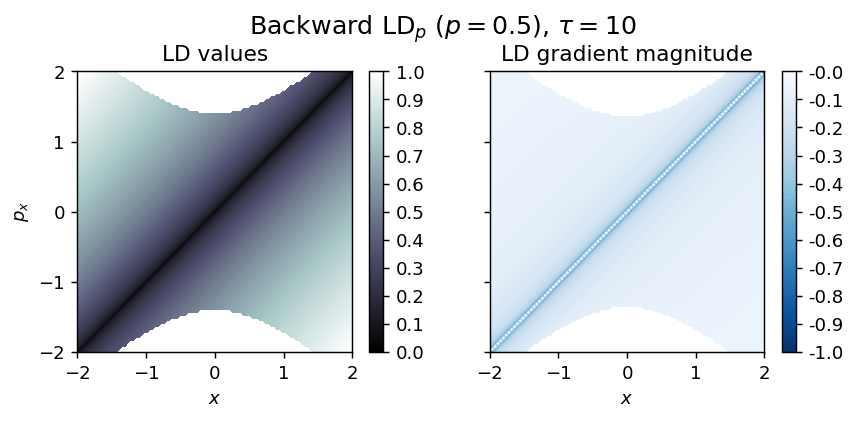

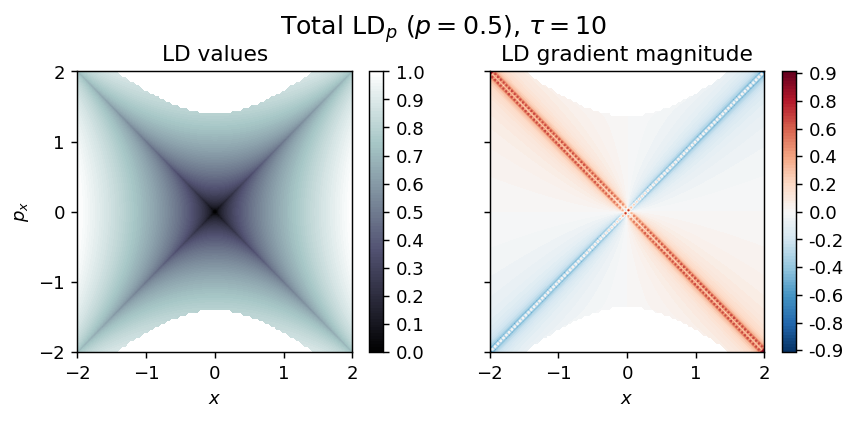

In [31]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)

draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value)

## HOW-TOs

### Change parameters of built-in vector fields

* _EXAMPLE_ Changed default parameters for a _vector field_

<span style='color:blue'><b>FIRST</b></span> Check vector field parameters using `help`

In [32]:
import pylds
help(pylds.vector_fields.HamCenter1D)

Help on function HamCenter1D in module pylds.vector_fields:

HamCenter1D(t, u, PARAMETERS=[1])
    Returns 1D Hamilton-Centre vector field at time t, for an array of points in phase space.
    Number of model parameters: 1 . PARAMETERS = [omega]
    Functional form: v = (omega*y, - omega*x), with u = (x, y)
    
    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase space
    
    u : array_like, shape(n,)
        points in phase space to determine vector field at time t
    
    PARAMETERS : list of floats
        vector field parameters
    
    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t



<span style='color:blue'><b>SECOND</b></span> Define the input `vector_field` to compute LDs, just editing the value of `PARAMETERS`, here we set `omega = 2.5`

In [33]:
import pylds
vector_field = lambda t,u : pylds.vector_fields.HamCenter1D(t, u, PARAMETERS=[2.5])

### Working with my own vector field: 1-DoF system

Setting up the code to draw the LDs of your own 1-DoF system requires only _THREE_ simple steps

_EXAMPLE_

Suppose we have a 2D vector field of the form

\begin{align*}
f_1(x, y) &= \alpha y \\
f_2(x, y) &= \beta \cdot cos(\gamma x^3)
\end{align*}

<span style='color:blue'><b>FIRST</b></span> Define `my_vector_field` function

See how it's done below

In [34]:
import numpy as np

def my_vector_field(t, u, PARAMETERS = [2, 0.5, 3]):
    """
    Returns a user-defined 1-DoF vector field at time t, for an array of points in phase-space.
    Number of model parameters: 1 . PARAMETERS = [alpha, beta, gamma]
    Functional form: v = (alpha*y, beta*x + gamma*x**4), with u = (x, y)
    
    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase-space.
        
    u : array_like, shape(n,)
        points in phase-space to determine vector field at common time t.
    
    PARAMETERS : list of floats
        vector field parameters
    
    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase-space at time t
    """
    x, y = u.T
    ##############################################
    #
    # CHANGE STUFF BELOW ONLY
    #
    ##############################################
    # Hamiltonian Model Parameter
    alpha, beta, gamma = PARAMETERS
    v = np.array([ alpha * y, beta * np.cos(gamma * x**3)]).T
    ##############################################
    #
    # CHANGE STUFF ABOVE ONLY
    #
    ##############################################    
    return v

Then, the input `vector_field` for computation of LDs will be

In [35]:
vector_field = my_vector_field

<span style='color:blue'><b>SECOND</b></span> Set your general input parameters

In [36]:
import pylds

# Integration parameters
tau = 8 # Length integration

# Lp-norm, p-value
p_value = 1/2

# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [100, 100]

In [37]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)] # Grid to sample Initial Conditions

<span style='color:blue'><b>THIRD</b></span> Compute and Visualise your desired Lagrangian Descriptors

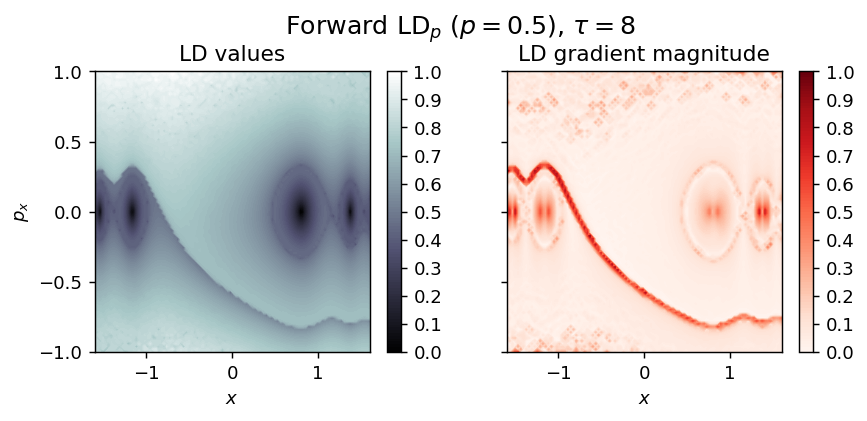

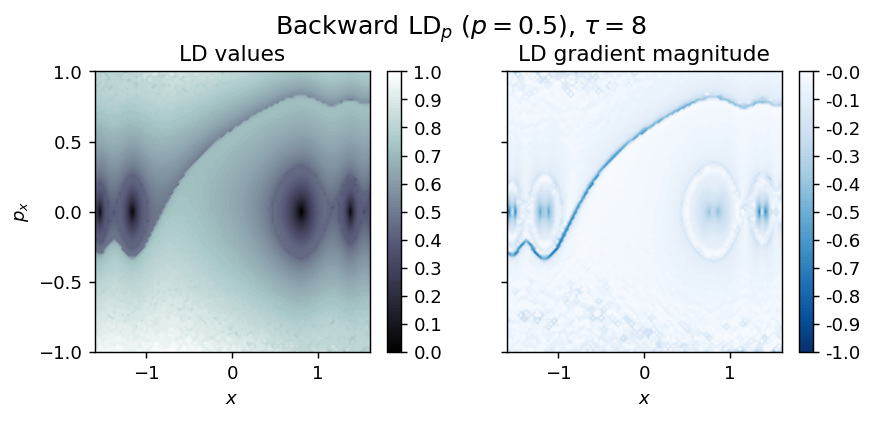

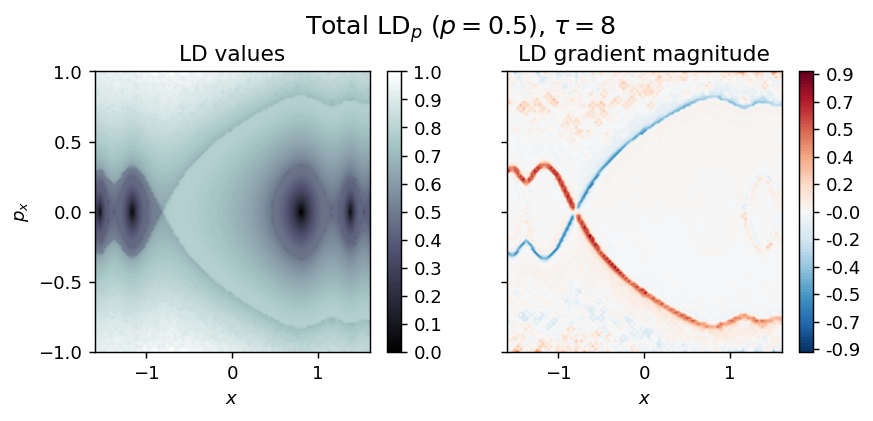

In [38]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)

draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value)

### Working with my own vector field: 2-DoF system

Setting up the code to draw the LDs of your own 2-DoF system requires only _FOUR_ simple steps

_EXAMPLE_ Here we chose a Hamiltonian system with a _Double well potential_

_Energy_

\begin{equation*}
H(x, p_x) = K + V = \frac{1}{2} (p_x^2 + p_y^2) + \frac{1}{2}(y^2 - x^2 + \frac{1}{2} x^4)
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} =  p_x \\
 \dot{y} &= \frac{\partial H}{\partial p_y} = p_y  \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} =  x - x^3 \\
 \dot{p}_y &= -\frac{\partial H}{\partial y} =  -y \\
 \end{align*}

<span style='color:blue'><b>FIRST</b></span> Define `my_vector_field` function

In [39]:
import numpy as np

def my_vector_field(t, u, PARAMETERS = [None]):
    """
    Returns 2-DoF vector field (Double Well system), for an array of points in phase space.
    Number of model parameters: 0 . PARAMETERS = [None]
    Functional form: v = (p_x, p_y, x - x**3, -y), with u = (x, y, p_x, p_y)
    
    Parameters
    ----------  
    t : float
        fixed time-point of vector field, for all points in phase space.
        
    u : array_like, shape(n,)
        Points in phase space.
        
    PARAMETERS : list of floats
        Vector field parameters.
    
    Returns
    -------
    v : array_like, shape(n,)
        Vector field corresponding to points u, in phase space at time t.
    """
    N_dims = u.shape[-1]
    points_positions = u.T[:int(N_dims/2)]
    points_momenta = u.T[int(N_dims/2):]
    x, y = points_positions
    p_x, p_y = points_momenta 
    
    # Hamiltonian Model Parameter
    
    # Vector field defintion
    v_x   =  p_x
    v_y   =  p_y
    v_p_x =  x - x**3
    v_p_y = -y
    v = np.array([v_x, v_y, v_p_x, v_p_y]).T
    return v

<span style='color:blue'><b>SECOND</b></span> Define `my_potential` energy function

In [40]:
def my_potential(positions, PARAMETERS = None):
    x, y = positions.T
    # Function parameters
    # None
    # Potential energy function
    V = (1/4)*x**4 - (1/2)*x**2 + (1/2)*y**2
    return V

<span style='color:blue'><b>THIRD</b></span> Set your general input parameters

In [41]:
# Integration parameters
tau = 10

# Lp-norm, p-value
p_value = 1/2

# Mesh visualisation slice parameters
H0 = 1 # Energy
ax1_min,ax1_max = [-2, 2]
ax2_min,ax2_max = [-2, 2]
N1, N2 = [200, 200]

# Box escape condition
box_boundaries = False

# Miscellaneous grid parameters
dims_fixed = [0,1,0,0] # Variable ordering (x y p_x p_y)
dims_fixed_values = [0] # This can also be an array of values
dims_slice = [1,0,1,0] # Visualisation slice
momentum_sign = 1 # Direction of momentum that defines the slice - (1) positive / (-1) negative

In [42]:
potential_energy = my_potential
vector_field = my_vector_field

slice_parameters = [[ax1_min, ax1_max, N1],[ax2_min, ax2_max, N2]]

grid_parameters = {
        'slice_parameters' : slice_parameters,
        'dims_slice' : dims_slice,
        'dims_fixed' : [dims_fixed, dims_fixed_values],
        'momentum_sign' : momentum_sign,
        'potential_energy': potential_energy,
        'energy_level': H0
    }

<span style='color:blue'><b>FOURTH</b></span> Compute and Visualise your desired Lagrangian Descriptors

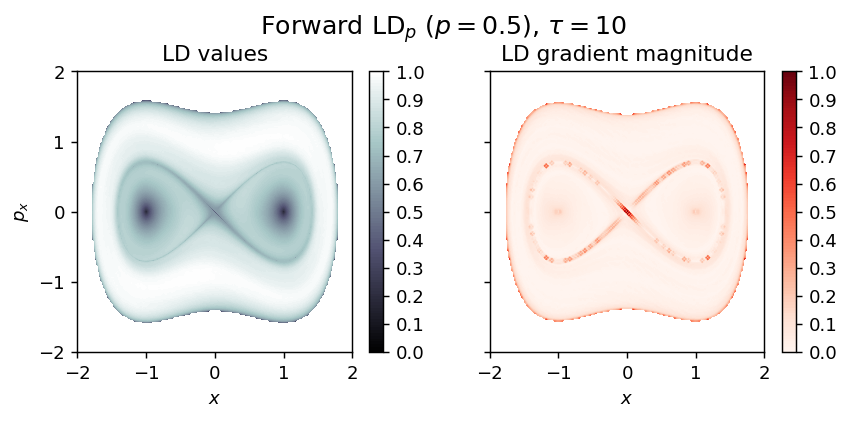

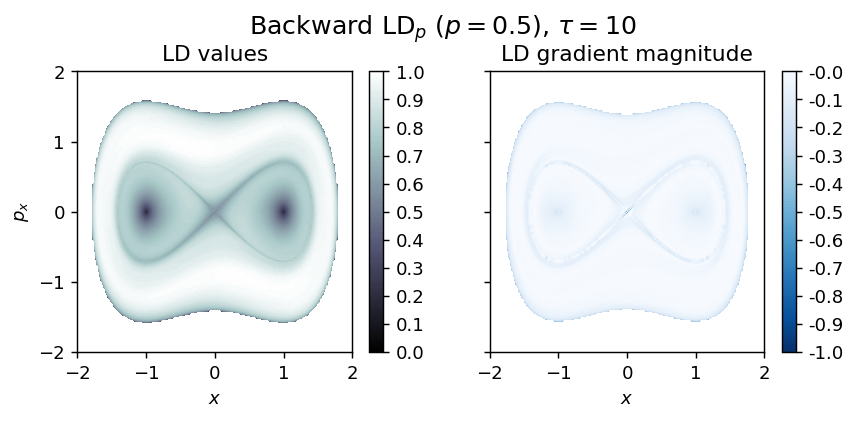

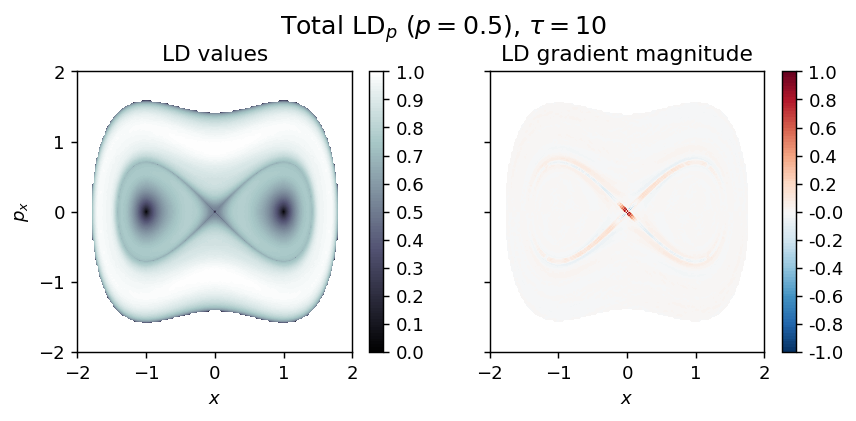

In [43]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)

draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value)